In [1]:
%matplotlib inline


기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기
********************************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_
  **번역**: `황성수 <https://github.com/adonisues>`_


단어를 분류하기 위해 기초적인 문자-단위 RNN을 구축하고 학습 할 예정입니다.
이 튜토리얼에서는 (이후 2개 튜토리얼과 함께) NLP 모델링을 위한 데이터 전처리를
`torchtext` 의 편리한 많은 기능들을 사용하지 않고 어떻게 하는지 "기초부터(from scratch)"
보여주기 떄문에  NLP 모델링을 위한 전처리가 저수준에서 어떻게 진행되는지를 알 수 있습니다.
문자-단위 RNN은 단어를 문자의 연속으로 읽어 들여서 각 단계의 예측과
"은닉 상태(Hidden State)" 출력하고, 다음 단계에 이전 은닉 상태를 전달합니다.
단어가 속한 클래스로 출력이 되도록 최종 예측으로 선택합니다.

구체적으로, 18개 언어로 된 수천 개의 성(姓)을 훈련시키고,
철자에 따라 이름이 어떤 언어인지 예측합니다:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**추천 자료:**

Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다:

-  https://pytorch.org/ 설치 안내
-  :doc:`/beginner/deep_learning_60min_blitz` PyTorch 시작하기
-  :doc:`/beginner/pytorch_with_examples` 넓고 깊은 통찰을 위한 자료
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료

RNN과 작동 방식을 아는 것 또한 유용합니다:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   실생활 예제를 보여 줍니다.
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   LSTM에 관한 것이지만 RNN에 관해서도 유익합니다.

데이터 준비
==================

.. NOTE::
   `여기 <https://download.pytorch.org/tutorial/data.zip>`__ 에서 데이터를 다운 받고,
   현재 디렉토리에 압축을 푸십시오.

``data/names`` 디렉토리에는 "[Language].txt" 라는 18 개의 텍스트 파일이 있습니다.
각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어 있습니다
(그러나, 유니코드에서 ASCII로 변환해야 함).

각 언어 별로 이름 목록 사전 ``{language: [names ...]}`` 을 만듭니다.
일반 변수 "category" 와 "line" (우리의 경우 언어와 이름)은 이후의 확장성을 위해 사용됩니다.

.. NOTE::
역자 주:  "line" 에 입력을 "category"에 클래스를 적용하여 다른 문제에도 활용 할 수 있습니다.
여기서는 "line"에 이름(ex. Robert )를 입력으로 "category"에 클래스(ex. english)로 사용합니다.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('sentiment/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('sentiment/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['sentiment\\neg_tweets.txt', 'sentiment\\pos_tweets.txt']
Slusarski


이제 각 ``category`` (언어)를 ``line`` (이름)에 매핑하는 사전인
``category_lines`` 를 만들었습니다. 나중에 참조 할 수 있도록
``all_categories`` (언어 목록)와 ``n_categories`` 도 추적합니다.




In [3]:
print(category_lines['pos_tweets'][:5])

[" I cheer myself up when I'm down by listening to my playlist called, Genius Ballads and Cellos. I love my iPod and my taste of music.", ' just watched the movie Wanted... it was pretty darn good.', " now I'm happy ", "plotting like i'm mike..'game planpass the ball to lebron AT ALL TIMES and DONT FOUL'..certainly we'll win  haha..go cavs goooo", ' mcdonalds with my litto sis aka cuzin lol cristyyyyy ']


이름을 Tensor로 변경
--------------------------

이제 모든 이름을 체계화 했으므로, 이를 활용하기 위해 Tensor로
전환해야 합니다.

하나의 문자를 표현하기 위해, 크기가 ``<1 x n_letters>`` 인
"One-Hot 벡터" 를 사용합니다. One-Hot 벡터는 현재 문자의
주소에만 1을 값으로 가지고 그외에 나머지는 0으로 채워진다.
예시 ``"b" = <0 1 0 0 0 ...>`` .

단어를 만들기 위해 One-Hot 벡터들을 2 차원 행렬
``<line_length x 1 x n_letters>`` 에 결합시킵니다.

위에서 보이는 추가적인 1차원은 PyTorch에서 모든 것이 배치(batch)에 있다고 가정하기
때문에 발생합니다. 여기서는 배치 크기 1을 사용하고 있습니다.




In [4]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어,글자 등을 벡터로 표현 할 때 단어,글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
동일하게 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용 할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


네트워크 생성
====================

Autograd 전에, Torch에서 RNN(recurrent neural network) 생성은
여러 시간 단계 걸처서 계층의 매개변수를 복제하는 작업을 포함합니다.
계층은 은닉 상태와 변화도(Gradient)를 가지며, 이제 이것들은 그래프 자체에서
완전히 처리되는 됩니다. 이는 feed-forward 계층과
같은 매우 "순수한" 방법으로 RNN을 구현할 수 있다는 것을 의미합니다.

역자 주 : 여기서는 교육목적으로 nn.RNN 대신 직접 RNN을 사용합니다.

이 RNN 모듈(대부분 `Torch 사용자를 위한 PyTorch 튜토리얼
<https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__ 에서 복사함)
은 입력 및 은닉 상태로 작동하는 2개의 선형 계층이며,
출력 다음에 LogSoftmax 계층이 있습니다.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과
이전의 은닉 상태 (처음에는 0으로 초기화)를 전달해야 합니다.
출력(각 언어의 확률)과 다음 은닉 상태 (다음 단계를 위해 유지)를
돌려 받습니다.




In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

효율성을 위해서 매 단계마다 새로운 Tensor를 만들고 싶지 않기 때문에
``letterToTensor`` 대신 ``lineToTensor`` 를 잘라서 사용할
것입니다. 이것은 Tensor의 사전 연산(pre-computing) 배치에 의해
더욱 최적화 될 수 있습니다.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.7017, -0.6847]], grad_fn=<LogSoftmaxBackward>)


보시다시피 출력은 ``<1 x n_categories>`` Tensor이고, 모든 항목은
해당 카테고리의 우도(likelihood) 입니다 (더 높은 것이 더 확률 높음).




학습
========
학습 준비
----------------------

학습으로 들어가기 전에 몇몇 도움되는 함수를 만들어야합니다.
첫째는 우리가 알아낸 각 카테고리의 우도인 네트워크 출력을 해석하는 것 입니다.
가장 큰 값의 주소를 알기 위해서 ``Tensor.topk`` 를 사용 할 수 있습니다.
역자 주: 네트워크 출력(각 카테고리의 우도)으로
가장 확률이 높은 카테고리 이름(언어)과 카테고리 번호 반환




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('pos_tweets', 1)


학습 예시(하나의 이름과 그 언어)를 얻는 빠른 방법도 필요합니다.:




In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = neg_tweets / line = MY TWEETS ARENT GOING THROUGH 
category = neg_tweets / line = CapitalM hugs Honey I wish I was going to one of the shows this year   It does suck a lot. At least nowadays we got youtube  
category = pos_tweets / line = alixsays, it's just like school except there's even more homework and everyone's a lot nicer normally 
category = neg_tweets / line = KWEE HOW ABOUT NO SCORE, GIRL LEBRON LET US DOWN 
category = neg_tweets / line = Been to opticians,referred to hospital tomorrow to check ever closing,painful,headache inducing eyes so won't be on air today  Catherine
category = neg_tweets / line = Think I've got hayfever 
category = pos_tweets / line = Cookin dinner for the family and luvin it  sendin luv to my hubbie,tw,luvladyt,tenise,nasa
category = neg_tweets / line = dhein i think Germany is boring. When i grow up i would move  to England or Canada 
category = neg_tweets / line = Fell asleep . . . Really didn't mean too  christina
category = neg_tweets 

네트워크 학습
--------------------

이제 이 네트워크를 학습하는데 필요한 예시(학습 데이터)들을 보여주고 추정합니다.
만일 틀렸다면 알려 줍니다.

RNN의 마지막 계층이 ``nn.LogSoftmax`` 이므로 손실 함수로
``nn.NLLLoss`` 가 적합합니다.




In [10]:
criterion = nn.NLLLoss()

각 학습 루프는 다음과 같습니다:

-  입력과 목표 Tensor 생성
-  0 로 초기화된 은닉 상태 생성
-  각 문자를 읽기

   -  다음 문자를 위한 은닉 상태 유지

-  목표와 최종 출력 비교
-  역전파
-  출력과 손실 반환




In [11]:
learning_rate = 0.005 # 이것을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

이제 예시 데이터를 사용하여 실행해야합니다. ``train`` 함수가 출력과 손실을
반환하기 때문에 추측을 화면에 출력하고 도식화를 위한 손실을 추적 할 수
있습니다. 1000개의 예시 데이터가 있기 때문에 ``print_every`` 예제만
출력하고, 손실의 평균을 얻습니다.




In [12]:
import time
import math

n_iters = 20000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

C:\Users\melon\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


5000 25% (2m 26s) 0.6538 Lakers and Orlando on NBA Finals Woohoo Sorry guys.. but your Nuggets  / pos_tweets ✓
10000 50% (4m 53s) 0.5298 MKoenigsberg  don't be a meanie it doesn't matter the weather out when i could go tanning anytime in a cancer machine / neg_tweets ✓
15000 75% (7m 9s) 0.6157 JonathanRKnight Hi Jon Great to hear from you See you on the cruise, I cannot wait Hope all is well on the Knight bus  You are loved / pos_tweets ✓
20000 100% (9m 23s) 0.5027 onehunnidt Amen to that. I hate the Lakers so I really hope Orlando takes it cuz the Cavs lost it  / neg_tweets ✓


결과 도식화
--------------------

``all_losses`` 를 이용한 손실 도식화는
네트워크의 학습을 보여준다:




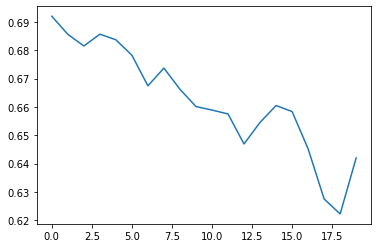

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

결과 평가
======================

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기위해
모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지를 나타내는
혼란 행열(confusion matrix)을 만듭니다. 혼란 행렬을 계산하기 위해
``evaluate()`` 로 많은 수의 샘플을 네트워크에 실행합니다.
``evaluate()`` 은 ``train ()`` 과 역전파를 빼면 동일합니다.




<ipython-input-14-dd97d7c57743>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-14-dd97d7c57743>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


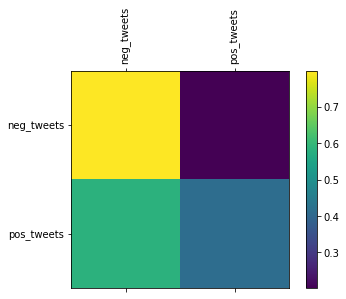

In [14]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시
할 수 있습니다. 예를 들어 한국어는 중국어로 이탈리아어로 스페인어로.
그리스어는 매우 잘되는 것으로 영어는 매우 나쁜것으로 보입니다.
(다른 언어들과 중첩 때문으로 추정)




사용자 입력으로 실행
---------------------




In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('good day!', n_predictions=1)
predict('This beef is so undercooked, its starting to eat the salad', n_predictions=1)

predict('hi there!!', n_predictions=1)
predict('happy', n_predictions=1)
predict('nice', n_predictions=1)
predict('bad', n_predictions=1)


> good day!
(-0.54) neg_tweets

> This beef is so undercooked, its starting to eat the salad
(-0.61) neg_tweets

> hi there!!
(-0.11) neg_tweets

> happy
(-0.67) neg_tweets

> nice
(-0.67) pos_tweets

> bad
(-0.40) neg_tweets


`실용 PyTorch 저장소
<https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
의 최종 버전 스크립트는 위 코드를 몇개의 파일로 분할했습니다.:

-  ``data.py`` (파일 읽기)
-  ``model.py`` (RNN 정의)
-  ``train.py`` (학습 실행)
-  ``predict.py`` (커멘드 라인 인자로 ``predict()`` 실행)
-  ``server.py`` (bottle.py를 사용하여 JSON API로 예측 제공)

학습과 네트워크 저장을 위해 ``train.py`` 실행.

이름으로 예측을 보기 위해 ``predict.py`` 실행:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

``server.py`` 를 실행하고 예측의 JSON 출력을 얻기 위해
http://localhost:5533/Yourname 방문.




연습
=========

-  "line -> category" 의 다른 데이터 집합으로 시도해보십시오, 예를 들어:

   -  단어 -> 언어
   -  이름 -> 성별
   -  캐릭터 이름 -> 작가
   -  페이지 제목 -> 블로그 또는 서브레딧

-  더 크고 더 나은 모양의 네트워크로 더 나은 결과를 얻으십시오.

   -  더많은 선형 계층을 추가해 보십시오
   -  ``nn.LSTM`` 과 ``nn.GRU`` 계층을 추가해 보십시오
   -  여러 개의 이런 RNN을 상위 수준 네트워크로 결합해 보십시오


